#### This code generates large dataframe containing multiple timeseries

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#### parameters to set

In [11]:
n_series = 6
n_timesteps = 8*24*3600 # 8 days

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

#### generate normal data

In [12]:
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df[s]=pd.Series(v)
df['Flag']=0
#df.head()

#### generate anomalies

In [13]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = (n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    for s in affects:
        df.loc[start:end,s] = df.loc[start:end,s] + random.random() * 0.3
    if len(affects)>1:
        df.loc[start:end,"Flag"]=1
        

#### enforce range

In [14]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

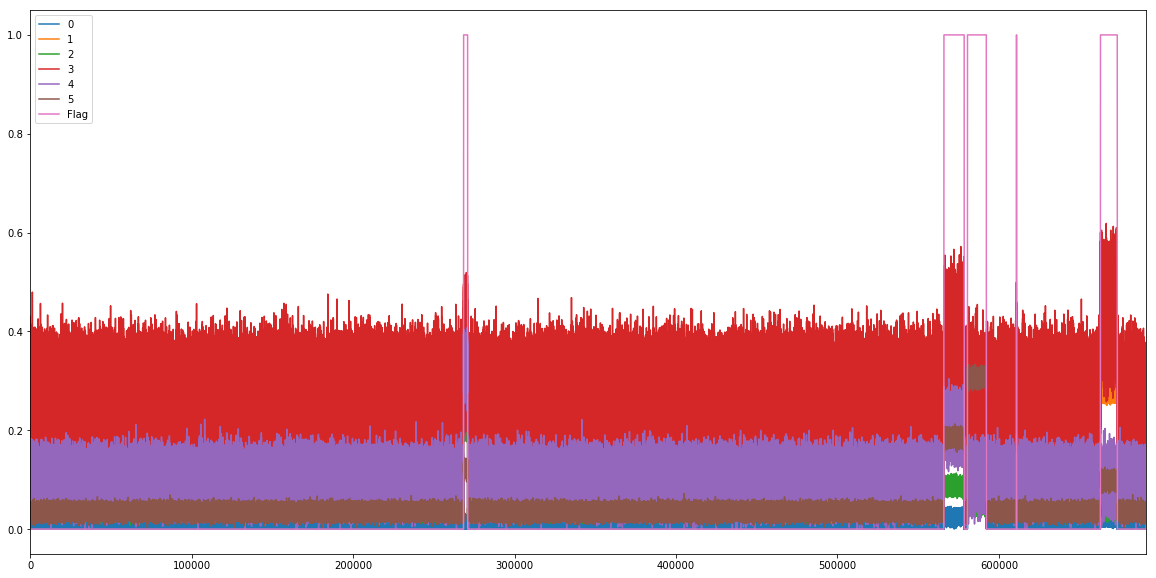

In [15]:
df.plot(figsize=(20,10))
#print df[147599]

#### running BDT

In [16]:
# clf = AdaBoostClassifier(n_estimators=100)
# y=df.Flag
# X=df.loc[:,range(n_series)]
# scores = cross_val_score(clf, X, y)
# print(scores)
predicted_flag_array = np.zeros((24*3600), dtype=np.int)
auc_score_array = np.zeros((24*3600), dtype=np.float)
score_holder_array = np.zeros(3600, dtype=np.float)
anomaly_array = np.ones(3600, dtype=np.int)
not_anomaly_array = np.zeros(3600, dtype=np.int)

#print df

#trying to print out the columns where the flag is 1

#if (df.iloc[ 2:, -1:] == 1):
#    print df
#print df.iloc[ :, -1:]
#if(df.iloc[-1] == 1):
#    print df

#### Train a model for all hours after the first day

In [17]:
#separate data into Reference and Subject
def trainer(reference, subject):
    refTrainSize = (int)(reference.shape[0] * 0.7) #training size of reference data is 70% of the data
    subTrainSize = (int)(subject.shape[0] * 0.7) #training size of subject data is 70% of the data
    
    reference.loc[:].Flag = 0 # Flagging the reference data as 0
    X_ref = reference.loc[:, range(n_series)] #refers to the feature set data
    y_ref = reference.Flag #refers to the label data
    
    subject.loc[:].Flag = 1 # Flagging the subject data as 1
    X_sub = subject.loc[:, range(n_series)] #refers to the feature set data
    y_sub = subject.Flag #refers to the label data

    #separate Reference into Train and Test
    X_ref_train = X_ref.loc[:refTrainSize, range(n_series)] #take 70% of the reference feature data
    X_ref_test  = X_ref.loc[refTrainSize:, range(n_series)] #take 30% of the reference feature data
    y_ref_train = y_ref.loc[:refTrainSize] #take 70% of the reference label data
    y_ref_test  = y_ref.loc[refTrainSize:] #take 30% of the reference label data

    #separate Subject into Train and Test
    X_sub_train = X_sub.loc[:subTrainSize, range(n_series)] #take 70% of the subject feature data
    X_sub_test  = X_sub.loc[subTrainSize:, range(n_series)] #take 30% of the subject feature data
    y_sub_train = y_sub.loc[:subTrainSize] #take 70% of the subject label data
    y_sub_test  = y_sub.loc[subTrainSize:] #take 30% of the subject label data

    #Combine reference and subject train datasets
    X_train_frames = [X_ref_train, X_sub_train] 
    X_train = pd.concat(X_train_frames, ignore_index=True) #combine the 70% training data features from both reference and subject
    
    y_train_frames = [y_ref_train, y_sub_train]
    y_train = pd.concat(y_train_frames, ignore_index=True) #combine the 70% training data label from both reference and subject

    #Combine reference and subject test datasets
    X_test_frames = [X_ref_test, X_sub_test]
    X_test = pd.concat(X_test_frames, ignore_index=True) #combine the 30% training data features from both reference and subject
    
    y_test_frames = [y_ref_test, y_sub_test]
    y_test = pd.concat(y_test_frames, ignore_index=True) #combine the 30% training data label from both reference and subject

    #Train model using the combined train data
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), n_estimators=50)
    clf.fit(X_train, y_train) 
    #train an AdaBoost model to be able to tell the difference between the reference and subject data

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    #use the trained AdaBoost model on the testing data. This is the predicted result
        
    from sklearn.metrics import roc_curve, auc
        
    #Calculate the AUC
        
    #from sklearn.preprocessing import LabelBinarizer

    # convert False and True to 0 and 1
    #lb = LabelBinarizer()
    #y_test_transformed = lb.fit_transform(y_test)
    #y_predict_transformed = lb.fit_transform(y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    #if (auc_score != 0.5):
    #    auc_score = 1.0
    
    score_holder_array.fill(auc_score)
    print ("score_holder_array = ", score_holder_array)
    print ("auc_score = ", auc_score) #finds the auc score. If auc~.5, then no anomalies. If auc>0.5, then there are anomalies
    
    #from sklearn.externals.six import StringIO  
    
    #if(auc_score >= 0.55):
        #decision_function = clf.staged_decision_function(X_test)
        #print ("decision_function = ", decision_function)
        #   tree.export_graphviz(clf)
        #  with open("tree.txt", "w") as f:
        #     f = tree.export_graphviz(clf, out_file=f)
        #dot_data = StringIO() 
        #tree.export_graphviz(clf, out_file=dot_data) 
        #graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
        #graph.write_pdf("iris.pdf") 
    
    return [clf, auc_score]

In [18]:
from graphviz import Source
from sklearn import tree
def drawTree(clf, sequenceNumber, auc_score):
    estimators = clf.estimators_ 
    decision_tree = estimators[0]
    
    # This loop is not needed because AdaBoostClassifier uses 1 depth of trees
    # for dtree in estimators:
    #    if (dtree.max_depth > decision_tree.max_depth):
    #        decision_tree = dtree
    graph = Source(tree.export_graphviz(decision_tree, out_file=None))
    
    # display tree diagram in Jupyter
    graph.format = 'png'
    graph.render('dtree_render',view=True)
    
    # save the tree diagram into PNG file
    png_bytes = graph.pipe(format='png')
    with open('decision_tree_{0}_{1}.png'.format(sequenceNumber, auc_score),'wb') as f:
        f.write(png_bytes)

ImportError: No module named 'graphviz'

#### Calculate AUC

In [ ]:
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

n = 24*3600 # number of seconds in the first day
m = 0
hour = 3600
k = 0
#trains an AdaBoost model for every hour after the first day
while(n <= n_timesteps):
    k = k + 1
    ref = df[m:n] #reference data refers to the data collected from the first day
    ref_reset_index = ref.reset_index(drop=True)
    
    sub = df[n:n+hour] #subject data refers to the data collected from the last hour
    sub_reset_index = sub.reset_index(drop=True)
    
    clf, auc_score = trainer(ref_reset_index, sub_reset_index)
    
    # detect and record anormaly                
    if(auc_score >= 0.55):
        #or auc_score <= 0.45
        predicted_flag_array = np.append(predicted_flag_array, anomaly_array)
        drawTree(clf, k, auc_score)
    else:
        predicted_flag_array = np.append(predicted_flag_array, not_anomaly_array)
    
    auc_score_array = np.append(auc_score_array, score_holder_array)
        
    m = m + hour
    n = n + hour
    
    print("n = ", n)
    print("score_holder_array = ", score_holder_array)
    print("auc_score_array = ", auc_score_array)
    print("predicted_flag_array =", predicted_flag_array)
        
# convert False and True to 0 and 1
#lb = LabelBinarizer()
#y_test_transformed = lb.fit_transform(y_test)
#y_predict_transformed = lb.fit_transform(y_predict)
#fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
#auc_score = auc(fpr, tpr) #calculate the AUC score
#print auc_score #finds the auc score. If auc~.5, then no anomalies. If auc>=0.55 or <=0.45, then there are anomalies

In [ ]:
#X=df.loc[:,range(n_series)] # get all the features
#y_predict = clf.predict(X)  # predict whole list of Flags
y_predict_df = pd.DataFrame(predicted_flag_array[0:n_timesteps], columns=['Predict_Flag']) #label my predicted anomalies
# X_test_reset_index = X_test.reset_index(drop=True)

x_y_combined = pd.concat([df, y_predict_df], axis=1) #append the column to the right of the original table
x_y_combined.plot(style=['-', '-', '-', '-', '-', '-', '-', 'bs--'], figsize=(20,10))

In [ ]:
y_predict_df.plot(style=['bs--'], figsize=(20,10))

In [ ]:
half_array = np.zeros(n_timesteps, dtype=np.float)
half_array.fill(0.5)
#print half_array
half_df = pd.DataFrame(half_array[0:n_timesteps], columns=['AUC = 0.5'])

upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
tuner2 = pd.concat([tuner, half_df], axis=1)
tuner3 = pd.concat([tuner2, upper_threshold_df], axis=1)
tuner3.plot(style=['bs--', '-', '-', '-'], figsize=(20,10))